# Predicting H1N1 Vaccination

![img](./images/cdc.jpg)

##### Author

Xiaohua Su

## Overview

There is a need to increase vaccination rates in the US. Having high vaccination rates will allow for another layer of safeguard against a certain disease by lowering the spread of it with the hopes of achieving herd immunity. With this added layer of protection for vaccine, people will not get severely sick from the disease or possibly die from it. As such, the CDC wants to create a model that can predict whether someone has gotten a vaccine. I will present to you model that specifically predicts whether or not someone got a H1N1 vaccine during the 2009-2010 H1N1 pandemic as there is survey data available for this vaccine. The model performed with an accuracy of 84% on unseen data with an F1 score of about 0.53. Using this model as the basis, a new model can then be created in order to locate which region many of these unvaccinated people are and strategies to get these individuals vaccinated such as free vaccine clinics, can then be further discussed after examination of the landscape.

## Problem

The CDC has tasked us to create a model that can accurately predict who has been vaccinated and who hasn't, in order to input into another model to locate these spots of where there is low vaccination rates. 

Using my model, we can predict whether an individual has been vaccinated or not. Using, this information, the CDC may be able to target individuals in specific locations to get vaccinated using outreach programs.

## Data

The data that was used in to create the model was taken from [DrivenData](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/). In order to access the data from DrivenData, you'll need to create an account and sign up for the competition. The data is also available on this github in my [data folder](https://github.com/xiaohua-su/Predicting_H1N1_Vaccination/tree/main/data). This data was derived from the CDC’s. It contains basic information on the individual such as their education levels, `race`, `gender`, `age_group` and their opinions on the topic of H1N1 and Flu vaccine such effectiveness. Sensitive Information about the individual such as what region they’re located in, employment industry and occupation were already masked in this dataset. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from model import *
from get_features import *
import pickle
import warnings

The model library was taken from Flatiron's Workflow with pipelines lecture. Adjustments and addition of a method was added into the model.py file. The get_feature file was taken from [Haupt J. github](https://johaupt.github.io/blog/columnTransformer_feature_names.html).

In [2]:
df = pd.read_csv('./data/training_set_features.csv')
df2 = pd.read_csv('./data/training_set_labels.csv')

A test set_feature was provided as well but unfortunately the set_labels that contain the target is with-held for the DataDriven competition. As such for the purposes of model testing, a train-test split will be performed on the training data provided. 

# Data Inspection

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
df2

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
df.education.value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [8]:
df.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [9]:
df.employment_industry.value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [10]:
df.employment_occupation.value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

This makes sense as to why there would be so many missing values for the columns `employment_industry` and `employment_occupation`.

In [11]:
df.health_insurance.value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [12]:
df.race.value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

We do not want to introduce racial bias into our model as such we'll be dropping this feature. 

In [13]:
df.child_under_6_months.value_counts()

0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64

In [14]:
df.hhs_geo_region.value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

In [15]:
df.isna().sum().sum()
#too many nulls in general to drop all of them

60762

In [16]:
df2.isna().sum().sum()

0

## Data Cleaning before Train-test split

In [17]:
df3 = pd.concat([df,df2], axis = 1)

In [18]:
df3

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,26702,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,26703,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,26704,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,26705,0,0


In [19]:
df3.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [20]:
df3.employment_status.isna().sum()

1463

In [21]:
#unemployed + not in labor force
10231 + 1453 

11684

In [22]:
df3.employment_industry.isna().sum()

13330

There's is more null in than the total amount of people not actively working.

In [23]:
#how much nulls should remain if we replace those that had N/A to not applicable for the employment industry
13330 - 11684 

1646

It make sense that those that are not active in the workforce would not have not have an employment occupation and industry. As such, we will replace the occupation and industry to `not applicable` where there is a `not in Labor Force` and `unemployment` for `employment_status`.

In [24]:
#replacement of some nan bases of whether they were employed or not in the labor force
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "not_applicable"

In [25]:
df3.employment_industry.isna().sum()

3099

In [26]:
df3.employment_occupation.isna().sum()

3239

In [27]:
df3.loc[df3['employment_status'] == "Unemployed", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Unemployed", 'employment_occupation'] = "not_applicable"

In [28]:
df3.employment_industry.isna().sum()

1646

In [29]:
df3.employment_occupation.value_counts()

not_applicable    11684
xtkaffoo           1778
mxkfnird           1509
emcorrxb           1270
cmhcxjea           1247
xgwztkwe           1082
hfxkjkmi            766
qxajmpny            548
xqwwgdyp            485
kldqjyjy            469
uqqtjvyb            452
tfqavkke            388
ukymxvdu            372
vlluhbov            354
oijqvulv            344
ccgxvspp            341
bxpfxfdn            331
haliazsg            296
rcertsgn            276
xzmlyyjv            248
dlvbwzss            227
hodpvpew            208
dcjcmpih            148
pvmttkik             98
Name: employment_occupation, dtype: int64

In [30]:
df3.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


We see that there is of binary or multilabel numericals

In [31]:
df3.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [32]:
df3.seasonal_vaccine.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [33]:
X = df3.drop(['respondent_id','race', 'h1n1_vaccine', 'seasonal_vaccine'],
            axis = 1)
y = df3['h1n1_vaccine']

###  Train-test-split 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [35]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,not_applicable,not_applicable
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,not_applicable,not_applicable
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,not_applicable,not_applicable
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,not_applicable,not_applicable
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp


In [36]:
train_df = pd.concat([X_train,y_train], axis =1)

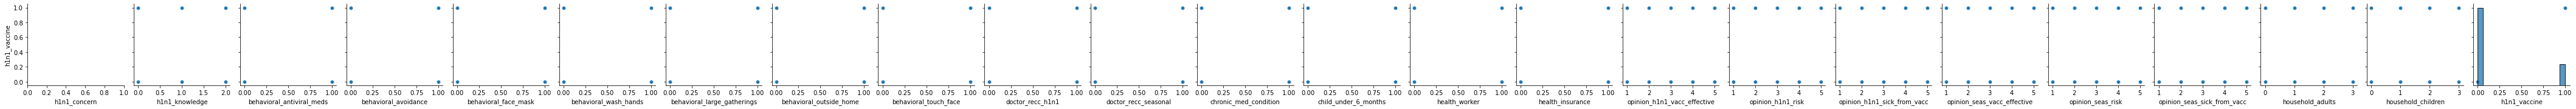

In [37]:
sns.pairplot(train_df, y_vars= 'h1n1_vaccine') #graph makes sense looking at the dictionary for the columns

##### Preprocessing and Transformation

In [38]:
y_train.value_counts(normalize = True)

0    0.787319
1    0.212681
Name: h1n1_vaccine, dtype: float64

Slight Class imbalance where we can SMOTE if we want to. We will SMOTE to .35 to ensure that our data is closer to even split in terms of our target classes.

In [39]:
numeric = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                  'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc']

cat_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation', 'age_group', 'education']

cat_pipe = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
scale_pipe = Pipeline(steps=[('scale_impute', SimpleImputer(strategy='most_frequent')),
                              ('scale', StandardScaler())])

In [40]:
ct = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_cols),
    ('scale', scale_pipe, numeric)
])

In [41]:
#for our simple model
ct_no_cat = ColumnTransformer(transformers=[
    ('scale', scale_pipe, numeric)
])

### Simple models and It's corresponding dummy classifier

In [42]:
dummy_simple = ImPipeline(steps=[
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('dummy', DummyClassifier(strategy='most_frequent'))
]).fit(X_train, y_train)

In [43]:
dummy_results = ModelWithCV(dummy_simple, 'dummy', X_train, y_train)

 The F1 on the training is 0.0 
 CV Results for `dummy` model:
            0.00000 ± 0.00000 f1
         
 
 


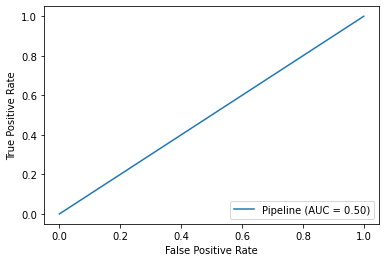

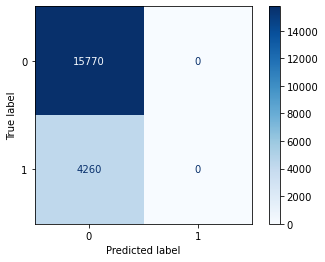

In [44]:
dummy_results.print_summary()

Using all our numerical columns as our baseline

In [45]:
X_simple = X_train[numeric]
y_simple = y_train

In [46]:
X_simple

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
15654,3.0,0.0,5.0,4.0,2.0,4.0,4.0,4.0
14559,2.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0
13752,1.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0
21985,1.0,1.0,3.0,1.0,1.0,4.0,1.0,1.0
18196,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0
...,...,...,...,...,...,...,...,...
10955,1.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0
17289,3.0,1.0,5.0,3.0,4.0,4.0,2.0,2.0
5192,2.0,2.0,3.0,2.0,4.0,5.0,4.0,4.0
12172,3.0,2.0,5.0,4.0,1.0,5.0,4.0,1.0


In [47]:
#confirming that I only have these continous features
X_simple.columns == numeric

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [48]:
X_simple_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_simple,y_simple)

In [49]:
simple_log = ModelWithCV(X_simple_pipe, 'logreg', X_simple, y_simple, cv_now = True)

In [50]:
log_score = simple_log.cv_mean

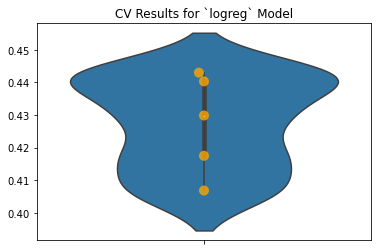

In [51]:
fig, ax = plt.subplots()

ax = simple_log.plot_cv(ax)

 The F1 on the training is 0.42861356932153394 
 CV Results for `logreg` model:
            0.42748 ± 0.01370 f1
         
 
 


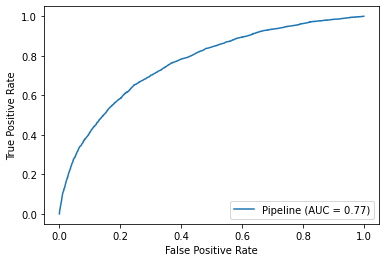

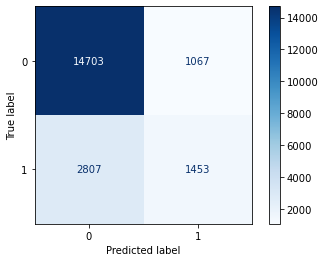

In [52]:
#plot_confusion_matrix(X_simple_pipe, X_simple, y_simple);
simple_log.print_summary()

The f1 of the logistic regression is better than dummy of 0. The AUC score is also better than the dummy being at 0.77 compared to the 0.50.

#### simple svc

In [53]:
#using kernel = linear as it needs to be this to get features
svc2_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)), 
    ('svc2', SVC(random_state=1, kernel='linear'))]).fit(X_simple,y_simple)

In [54]:
sv2_results = ModelWithCV(svc2_pipe, 'svc2', X_simple, y_simple, cv_now = True)

In [55]:
sv2_score = sv2_results.cv_mean

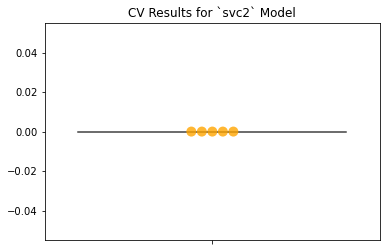

In [56]:
fig, ax = plt.subplots()

ax = sv2_results.plot_cv(ax)

 The F1 on the training is 0.0 
 CV Results for `svc2` model:
            0.00000 ± 0.00000 f1
         
 
 


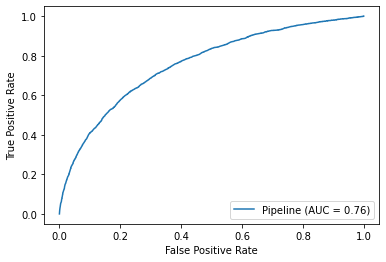

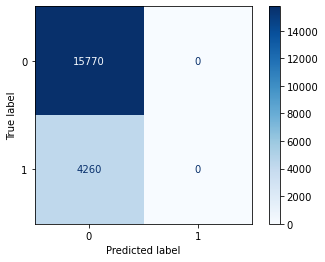

In [57]:
sv2_results.print_summary()

This linear SVC has a better auc score but the f1 is the same as dummy, so the linear kernel for SVC is not good for this.

#### simple KNN 

In [58]:
knn_p = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', KNeighborsClassifier())]).fit(X_simple,y_simple)

In [59]:
knn_result = ModelWithCV(knn_p, 'knn', X_simple, y_simple, cv_now = True)

In [60]:
knn_score = knn_result.cv_mean

 The F1 on the training is 0.5331724969843185 
 CV Results for `knn` model:
            0.39961 ± 0.00332 f1
         
 
 


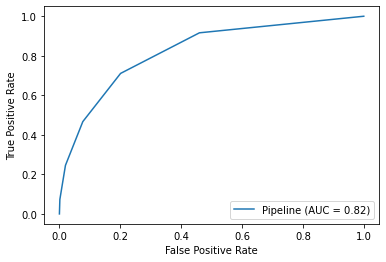

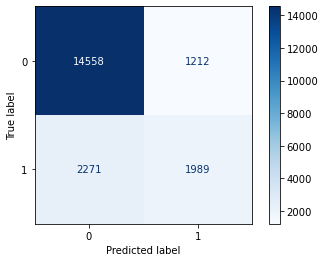

In [61]:
knn_result.print_summary()

It has a better auc compared to the other models. It's cross-validation f1 is lower compared to the training f1 indicating that this model is overfit (0.4 v 0.5) to some extent to the data.  

#### simple dtree

In [62]:
dtree_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', DecisionTreeClassifier(random_state=1))]).fit(X_simple,y_simple)

In [63]:
dtree_result = ModelWithCV(dtree_pipe, 'dt', X_simple, y_simple, cv_now = True)

In [64]:
dtree_score = dtree_result.cv_mean

 The F1 on the training is 0.6371456776195176 
 CV Results for `dt` model:
            0.37438 ± 0.00546 f1
         
 
 


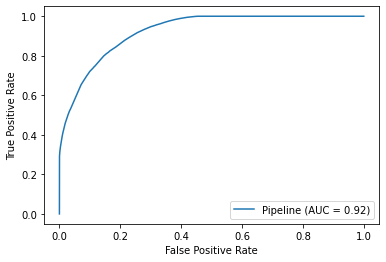

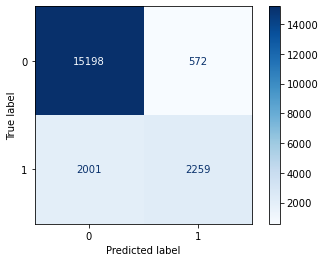

In [65]:
dtree_result.print_summary()

Better than the dummy, however overfit since training f1 is 0.64 and validation is 0.4.So, may be on-par with the knn model.But such a high AUC adds to evidence that it maybe extremely overfit since decision trees are known to be prone to overfitting.

##### let's put multiple default models in voting!

In [66]:
voting = VotingClassifier(estimators= [
    ('lr', X_simple_pipe),
    ('knn', knn_p),
    ('dt', dtree_pipe)],
).fit(X_simple,y_simple)

In [67]:
voting_result = ModelWithCV(voting, 'voting', X_simple, y_simple, cv_now = True)

In [68]:
voting_score = voting_result.cv_mean

In [69]:
voting_score

0.4058372027960047

In [70]:
preds = voting.predict(X_simple)

f1_score(y_simple, preds)

0.5523398128149748

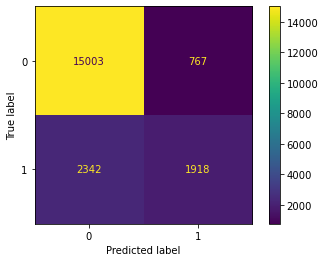

In [71]:
plot_confusion_matrix(voting, X_simple, y_simple);

The voting performed about the same as the decision and knn, except that it is less overfit compared to the other two.

### Addition of more features

we will use all our features this time around and scale/transofrm it out to see if it does any better in predicting.

In [72]:
dummy_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('dummy', DummyClassifier(strategy='most_frequent'))
]).fit(X_train, y_train)

In [73]:
dummy_results = ModelWithCV(dummy_pipe, 'dummy', X_train, y_train)

 The F1 on the training is 0.0 
 CV Results for `dummy` model:
            0.00000 ± 0.00000 f1
         
 
 


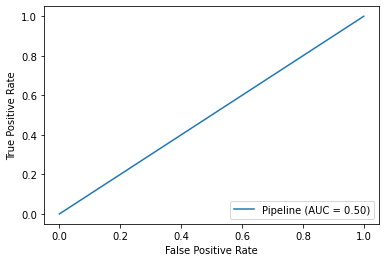

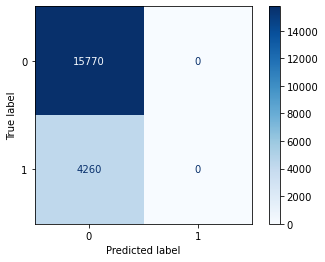

In [74]:
dummy_results.print_summary()

###### logistic regression

In [75]:
#no grid search performed
logreg_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
logreg_result = ModelWithCV(logreg_pipe,'log_reg',X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

 The F1 on the training is 0.5581950895819509 
 CV Results for `log_reg` model:
            0.55144 ± 0.01427 f1
         
 
 


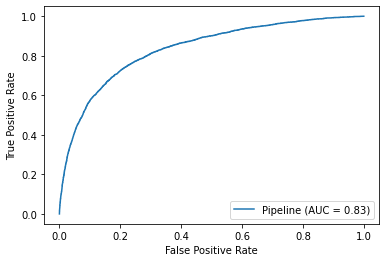

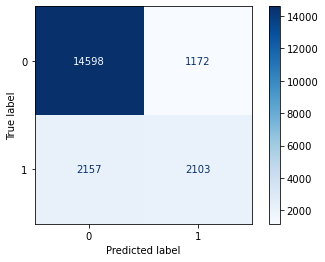

In [77]:
logreg_result.print_summary()

When including all our features the f1 is still better than the dummy. It is also better than our best simple models. The f1 score of this logistic regression is 0.55 compared to the 0.4 of the best simple, and the auc is 0.83.

###### knn model

In [78]:
knn_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', KNeighborsClassifier())
]).fit(X_train,y_train)

In [79]:
knn1_results = ModelWithCV(knn_pipe,'knn',X_train,y_train)

 The F1 on the training is 0.6570865685479198 
 CV Results for `knn` model:
            0.49020 ± 0.01048 f1
         
 
 


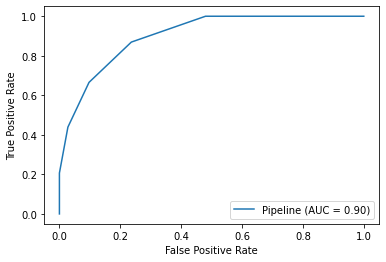

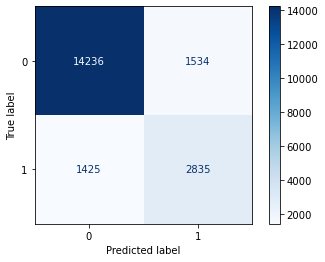

In [80]:
knn1_results.print_summary()

Better but like the simple KNN, it is overfit. The f1 cv score is 0.49 while the training recall is 0.65. It's worse than the more complex logistic regression model.

###### Decision Tree model

In [81]:
dt_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('dt', DecisionTreeClassifier(random_state=1))
]).fit(X_train,y_train)

In [82]:
# dt_pickle = 'dt_pipe.sav'
# pickle.dump(dt_pipe, open(dt_pickle, 'wb'))

In [83]:
# dt_pipe = pickle.load(open('dt_pipe.sav', 'rb'))

In [84]:
dt_results = ModelWithCV(dt_pipe,'dt',X_train,y_train) #0.7581627558662006

 The F1 on the training is 1.0 
 CV Results for `dt` model:
            0.43973 ± 0.00716 f1
         
 
 


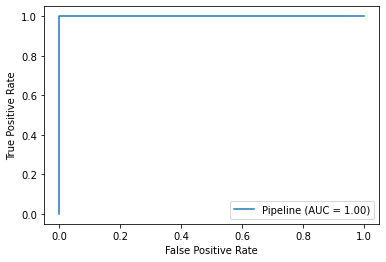

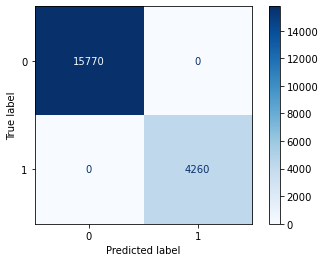

In [85]:
dt_results.print_summary()

The ROC-AUC, F1 and confusion matrix were of perfect scores of 1 and classification,which is a major red flag as models in reality should produce some errors no matter how small. This indicates that this decision tree overfitted to our data. The cv f1 shows that it performs at 0.44 which adds to the evidence of overfitness. Not only that but the f1 cv score is not better than the logistic regression of 0.55.

###### SVC model

In [86]:
svm_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('svm', SVC(random_state=1))
]).fit(X_train,y_train)

In [87]:
#takes a long time to load
cv_svm = ModelWithCV(svm_pipe,'svm',X_train,y_train)

 The F1 on the training is 0.6217757263100733 
 CV Results for `svm` model:
            0.55174 ± 0.01124 f1
         
 
 


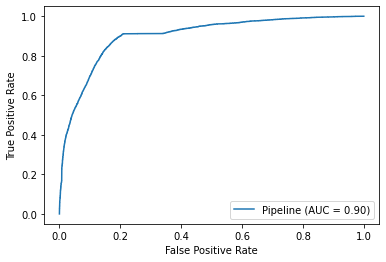

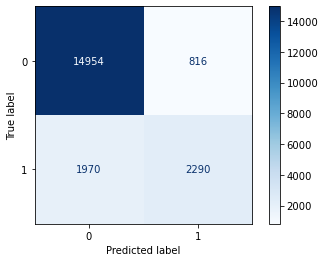

In [88]:
cv_svm.print_summary()

The F1 score is 0.55 which is on par with the logistic regression(better at the 4th decimal place). The ROC-AUC is the same as the KNN with it being 0.9 and the training F1 is 0.62 but evidence of slight overfitting from the model.

##### voting model

In [89]:
voting_complex = VotingClassifier(estimators= [
     ('lr', logreg_pipe),
     ('knn', knn_pipe),
     ('dt', dt_pipe)
 ], n_jobs=-1).fit(X_train,y_train)

In [90]:
voting_complex_results = ModelWithCV(voting_complex, 'voting', X_train, y_train) # 0.834648027958063

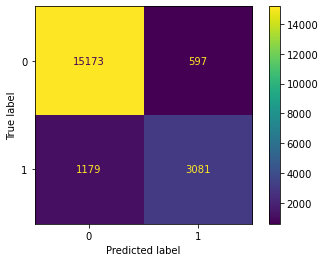

In [91]:
plot_confusion_matrix(voting_complex, X_train, y_train)

In [92]:
preds = voting_complex.predict(X_train)

f1_score(y_train, preds)

0.7762660619803476

In [93]:
voting_complex_results.cv_mean

0.5398363101480647

Overfit because the F1 and the cv F1 are not around the same value, with it being 0.77 and 0.54 respectively. It's not the best model as the logistic and SVM performed better.

##### let's try out bagging instead 

In [94]:
#bagging- no need to pickle as it doesn't take too long to run
bagdt_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('bag', BaggingClassifier(random_state= 1))
]).fit(X_train, y_train)

In [95]:
bagdt_result = ModelWithCV(bagdt_pipe, 'bagging', X_train, y_train)

 The F1 on the training is 0.9587841945288754 
 CV Results for `bagging` model:
            0.48368 ± 0.01822 f1
         
 
 


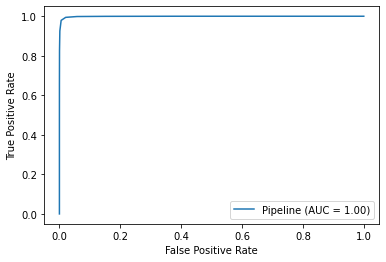

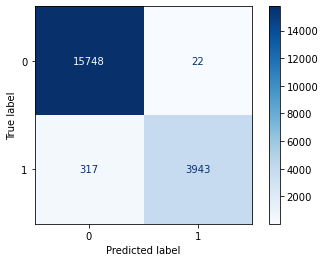

In [96]:
bagdt_result.print_summary()

Better than the decision tree by itself but it appears to also be super overfit with the f1 score being close to 1, and ROC-AUC being 1, while the cv f1 is 0.48.

##### random forest

In [97]:
rf_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rf', RandomForestClassifier(n_jobs=-1))
]).fit(X_train, y_train)

In [98]:
rf_result = ModelWithCV(rf_pipe, 'bagging', X_train, y_train)

 The F1 on the training is 0.9998826153304379 
 CV Results for `bagging` model:
            0.51362 ± 0.01710 f1
         
 
 


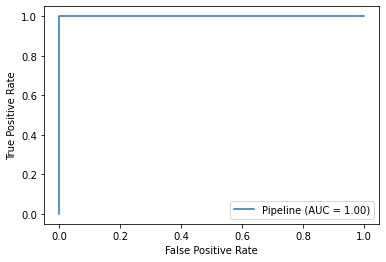

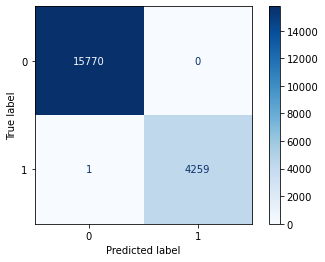

In [99]:
rf_result.print_summary()

Like the other tree models, this is overfit. The F1 and AUC score is essentially 1, while the F1 cv is 0.51.

### Model tuning

We will perform hypertuning using grid search on both the bagging and random forest model to drop the overfitting of these models and then seeing how well it does and logistic regression.

**Due the nature of the SVM model, 'lifting' our data to one extra dimension, a SVC gridsearch was not perform due to the big O issue that would be encountered. The fitting time will increase quadratically for the amount of rows with this type of algorithim since they would all have to be raised by one more dimension**

##### gridsearch logistic regression

In [100]:
logreg_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
logreg_param = {
     'logreg__penalty' : ['l2','l1'],
     'logreg__solver' : ['liblinear', 'saga'],
     'logreg__max_iter' : [200,300,400]
 }

In [102]:
logreg_grid = GridSearchCV(estimator=logreg_pipe, param_grid=logreg_param, scoring = 'f1', n_jobs=-1).fit(X_train,y_train)

In [103]:
logreg_grid.best_params_

{'logreg__max_iter': 200, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}

In [104]:
logreg_tune = ModelWithCV(logreg_grid.best_estimator_,'logreg_tune', X_train, y_train)

 The F1 on the training is 0.5592568015925681 
 CV Results for `logreg_tune` model:
            0.55322 ± 0.01356 f1
         
 
 


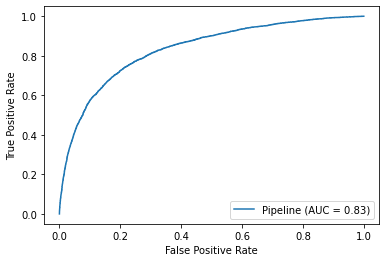

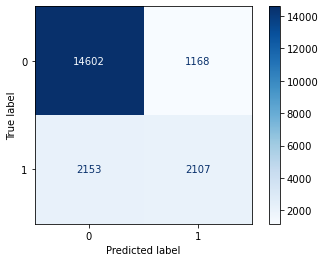

In [105]:
logreg_tune.print_summary()

The best logistic regression gave use the similar F1 results as the default logistic regression of 0.55. 

##### gridsearch bagging 

In [106]:
bagdt_pipe = ImPipeline(steps=[
     ('ct', ct),
     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
     ('bag', BaggingClassifier(random_state= 1))
 ]).fit(X_train, y_train)

In [107]:
 bag_params = {
     'bag__n_estimators' : [10,100,1000],
     'bag__max_features' : [5,10,15,20],
 }

In [108]:
bag_grid = GridSearchCV(estimator=bagdt_pipe, param_grid=bag_params,scoring = 'f1', n_jobs=-1).fit(X_train,y_train)

In [109]:
bag_grid.best_params_

{'bag__max_features': 20, 'bag__n_estimators': 10}

In [110]:
bag_tune = ModelWithCV(bag_grid.best_estimator_,'bag_tune', X_train, y_train)

 The F1 on the training is 0.4305097176384305 
 CV Results for `bag_tune` model:
            0.14500 ± 0.00837 f1
         
 
 


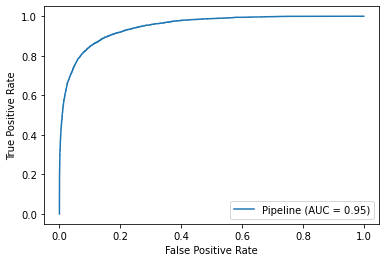

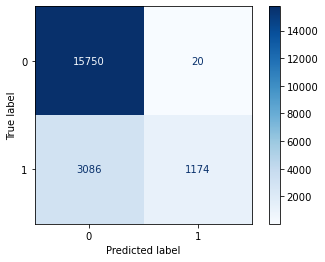

In [111]:
bag_tune.print_summary()

The two features results came out to be on the upper boundary of what was set. While it is ideal to run another grid search, we just need to move on for now as we also have to grid search our random forest first. I see that the model is still overfit since the AUC score is 0.98, and the F1 and F1 CV score are not close to each other. 

##### grid search random forest

In [112]:
 rf_pipe = ImPipeline(steps=[
     ('ct', ct),
     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
     ('rf', RandomForestClassifier(n_jobs=-1))
 ]).fit(X_train, y_train)

In [113]:
 rf_params = {
     'rf__n_estimators' : [10 ,100,200],
     'rf__criterion' : ['gini', 'entropy'],
     'rf__max_depth' : [5,10,20,25],
     'rf__min_samples_split' : [100,500,1000]
 }

In [114]:
 rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params,scoring ='f1' , n_jobs=-1,verbose=3).fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


In [115]:
rf_pickle = 'rf_gridsearch.sav'
pickle.dump(rf_grid, open(rf_pickle, 'wb'))

In [116]:
rf_grid = pickle.load(open('rf_gridsearch.sav', 'rb'))

In [117]:
rf_grid.best_score_

0.5187581056993323

In [118]:
rf_grid.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 20,
 'rf__min_samples_split': 100,
 'rf__n_estimators': 100}

In [119]:
rf_tune = ModelWithCV(rf_grid.best_estimator_,'bag_tune', X_train, y_train)

 The F1 on the training is 0.569228575502638 
 CV Results for `bag_tune` model:
            0.51596 ± 0.01518 f1
         
 
 


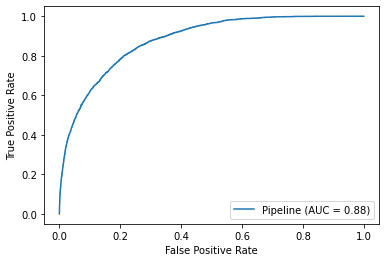

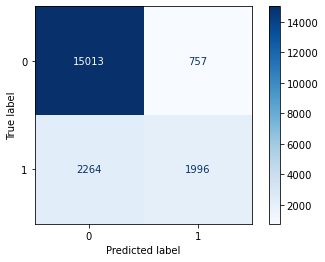

In [120]:
rf_tune.print_summary()

This model is better and less overfit compared to the default random forest as the F1 and cv F1 is 0.57 and 0.52 respectively.

#### rfe with 60

In [121]:
rf_pipe2 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 60)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
]).fit(X_train, y_train)

 The F1 on the training is 0.566577802722043 
 CV Results for `rf_pipe2` model:
            0.52672 ± 0.01935 f1
         
 
 


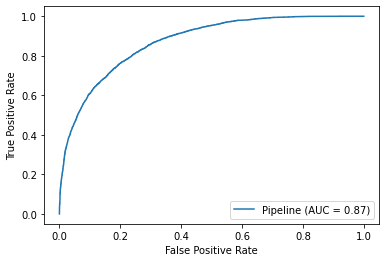

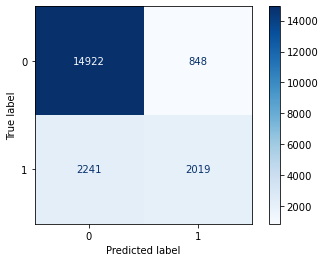

In [122]:
ModelWithCV(rf_pipe2, 'rf_pipe2', X_train, y_train).print_summary()

#### RFE of 100 selection

In [123]:
rf_pipe3 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 100)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   1.1s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  26.9s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.2s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  20.9s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.9s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  21.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.9s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  21.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.9s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipel

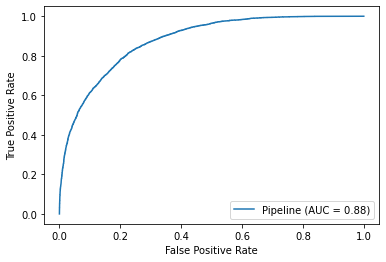

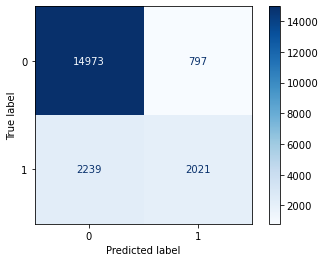

In [124]:
ModelWithCV(rf_pipe3, 'rf_pipe3', X_train, y_train).print_summary()

##### RFE with 25

In [125]:
rf_pipe4 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 25)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   1.2s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.6min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.7s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.3min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.6s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.3min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.6s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.3min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.6s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipel

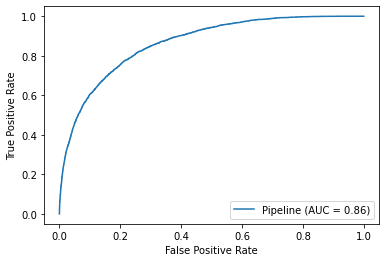

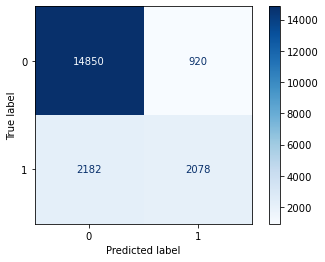

In [126]:
ModelWithCV(rf_pipe4, 'rf_pipe3', X_train, y_train).print_summary()

##### RFE with all features 

In [127]:
rf_pipe5 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 122)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   1.1s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.3s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.2s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.9s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.9s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.1s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.4s
[Pipel

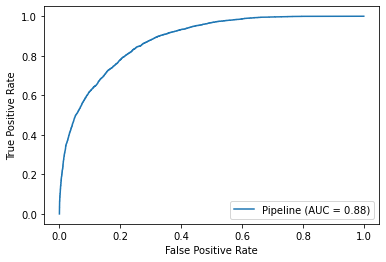

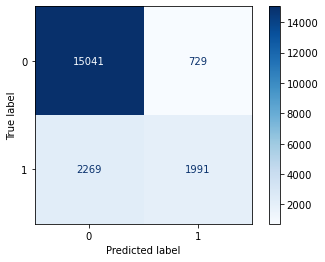

In [128]:
ModelWithCV(rf_pipe5, 'rf_pipe3', X_train, y_train).print_summary()

At about 60 features, there is diminishing returns in the number of columns and any increase of F1 score. The F1 score of having 60, 100, all features is about .57. The CV score doesn't differ by much by then. 

In [129]:
feature1 = pd.DataFrame(rf_pipe5.named_steps.rf.feature_importances_, index=get_feature_names(ct))

C:\Users\xiao\Documents\flatiron\projects\phase3project\get_features.py:36: UserWarning: Transformer cat_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\xiao\Documents\flatiron\projects\phase3project\get_features.py:36: UserWarning: Transformer scale_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
C:\Users\xiao\Documents\flatiron\projects\phase3project\get_features.py:36: UserWarning: Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [130]:
feature1.sort_values(0, ascending=False)[:10]

,0
ohe__x7_1.0,0.165381
ohe__x7_0.0,0.145470
scale__opinion_h1n1_vacc_effective,0.103813
scale__opinion_h1n1_risk,0.092259
scale__opinion_seas_risk,0.056300
scale__opinion_seas_vacc_effective,0.038714
ohe__x8_1.0,0.029758
ohe__x8_0.0,0.028220
ohe__x11_0.0,0.019436
ohe__x11_1.0,0.018236


Mapping out the OHE by manually looking at the columns.

In [131]:
cat_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation', 'age_group', 'education']

In [132]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,not_applicable,not_applicable
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,not_applicable,not_applicable
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,not_applicable,not_applicable
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,not_applicable,not_applicable
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp


Feature Importance according to our data:

- behavioral_touch_face yes/no
- opinion of the risk of h1n1
- h1n1 vaccine effectiveness
- season flu vaccine risk
- season flu vaccine effectiveness
- doc recommendation for the h1n1 vaccine
- child under 6 months

### Final Model Evaluation

We will perform two model evaluation as one is a slightly predictor but is a black box due to the kernel being used.The other can be used to gather feature importance of the model.

In [133]:
rf_pipe2 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 60)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
]).fit(X_train, y_train)

In [134]:
final_model = rf_pipe2

 The F1 on the training is 0.5456874466268147 
 CV Results for `final_model` model:
            0.53319 ± 0.03622 f1
         
 
 


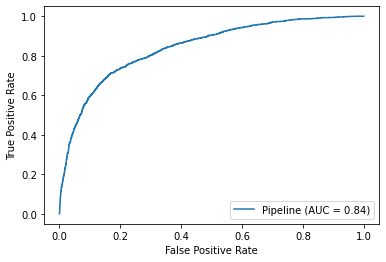

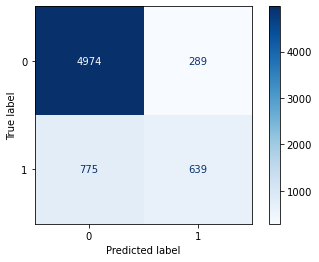

In [135]:
ModelWithCV(final_model, 'final_model', X_test, y_test).print_summary()

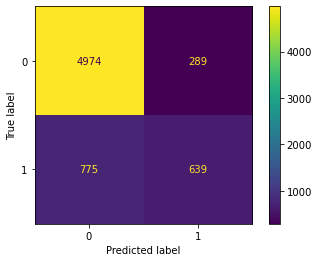

In [136]:
plot_confusion_matrix(final_model, X_test, y_test)

plt.savefig('cm.png')

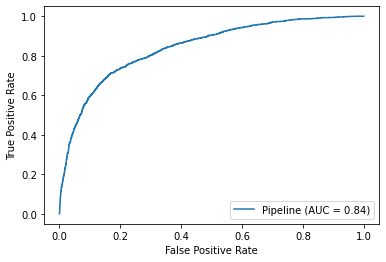

In [137]:
plot_roc_curve(final_model, X_test, y_test)
plt.savefig('roc.png')

In [138]:
svm_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('svm', SVC(random_state=1))
]).fit(X_train,y_train)

 The F1 on the training is 0.5655058043117744 
 CV Results for `final_model` model:
            0.57316 ± 0.02937 f1
         
 
 


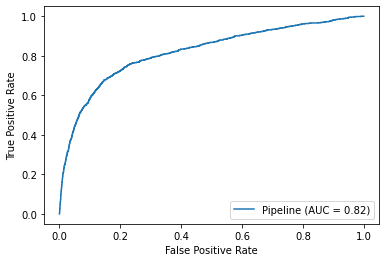

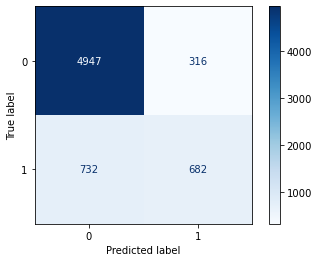

In [139]:
ModelWithCV(svm_pipe, 'final_model', X_test, y_test).print_summary()

They both performed about the same with the SVC being slightly better as expected base on the difference in the training model. But overall, both performed only slightly worse on unseen data in terms of F1 score.

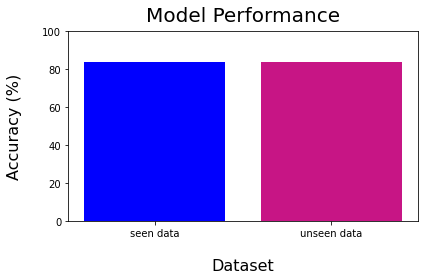

In [140]:
#Visualizing the SVC model
fig, ax= plt.subplots()

y = [84, 84] #the training accuracy and the test accuracy
X = ['seen data', 'unseen data']

plt.bar(x=X, height= y, color = ['blue', 'mediumvioletred'])

ax.set_title('Model Performance', fontsize='20', pad=10)
ax.set_xlabel('Dataset', fontsize='16', labelpad=20)
ax.set_ylabel('Accuracy (%)', fontsize='16', labelpad=20)
ax.set_ylim([0, 100])
plt.tight_layout()

plt.savefig('finalmodel_accuracy.png', dpi = 200 )

## Next Steps

Further tuning of model is needed to lower the misclassification of those that did or did not get the H1N1 vaccine. Not only that but refinement can be made to the data if access to the original dataset as the regions in which each individual was located is masked. As such, we are unable to do initial analysis on where those who were unvaccinated are. We would also want to test the model against the covid-19 vaccine confidence survey, as they have some of the same questions that was asked in the H1N1 survey, to see how well it’s able to predict if someone had the covid-19 vaccine to examine if it’s generalizable for other vaccines. 

# Conclusion

So, in conclusion, the model created was able to accurately predict whether someone had gotten the H1N1 vaccine or not about 84%. While this is good, further tuning of the model can be made, with more time and resources. Not only that, but with access to the region where the individual is located, I could make a model that can potentially predict locations of low vaccination rate. Testing the model against other vaccines such as COVID-19 will help make the model more generalizable as currently this model is optimized to look at the H1N1 vaccine specifically. It is difficult to be able to create a model that can generally predict who got a vaccine.The circumstances of when vaccines are implemented can vary and may be able to predict who got the vaccine better compared to a more general model. But a general model does have its own merits. My model today took a step towards creating such a generalizable predicting model that you the CDC are looking for to input into the a low vaccination hotspot model in order to target those inviduals. 